In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import os

import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

import otf.utils.error_surfaces as es
from otf import optim
from otf import time_integration as ti
from otf.system import base as system_base

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray
ndarray = np.ndarray

FIGURES_FOLDER = os.path.join(os.getcwd(), "figures", "partial-observations")
os.makedirs(FIGURES_FOLDER, exist_ok=True)

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    sigma, rho, beta = gs

    x, y, z = true

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    sigma, rho, beta = cs

    x, y, z = nudged

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


true0, assimilated0 = get_initial_values()

# System evolution parameters
g1, g2, g3 = 10, 28, 8 / 3
gs = jnp.array([g1, g2, g3])
cs_center = gs.copy()

mu = 20
observed_slice = jnp.s_[:2]

system = system_base.System_ModelKnown(
    mu, gs, None, observed_slice, assimilated_ode, true_ode
)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 200
sim_Tf = 400
sim_t_relax = 1

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

optimizer_options = {"optimizer": optax.adam(1e-2)}
optimizer_type = optim.OptaxWrapper

true, _ = solver.solve_true(true0, T0, sim_Tf, dt)
true_observed = true[:, observed_slice]

In [ ]:
surface_results = list()
n = 21
xn = n
yn = n
max_relative_step = 4

trajectory_results = list()
start_relative_position = (2.2, -0.5)

for i, seed in enumerate((0, 1, 2, 42)):
    dirs = es.get_dirs(cs_center, seed=seed)

    surface_result = es.get_surface(
        system,
        true_observed,
        solver,
        dt,
        T0,
        Tf,
        assimilated0,
        cs_center,
        dirs,
        true_actual=true,
        xn=xn,
        yn=yn,
        x_relative_bound=max_relative_step,
        y_relative_bound=max_relative_step,
    )

    system.cs = es.get_cs_from_relative_position(
        cs_center, dirs, start_relative_position
    )
    optimizer = optimizer_type(system, **optimizer_options)
    trajectory_result = es.get_trajectory(
        system,
        true_observed,
        solver,
        dt,
        T0,
        sim_Tf,
        sim_t_relax,
        assimilated0,
        optimizer,
        cs_center,
        dirs,
    )
    surface_results.append(surface_result)
    trajectory_results.append(trajectory_result)

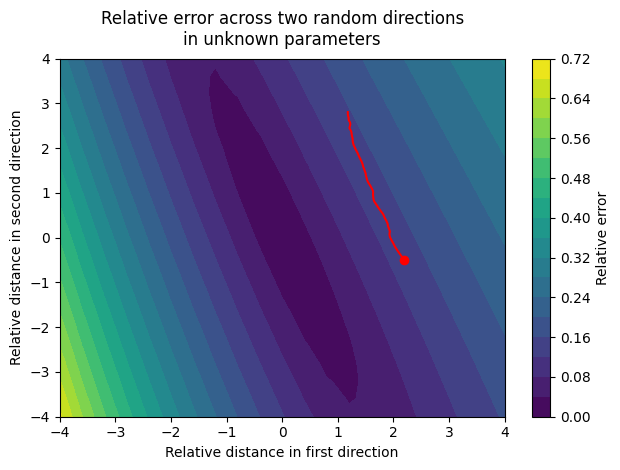

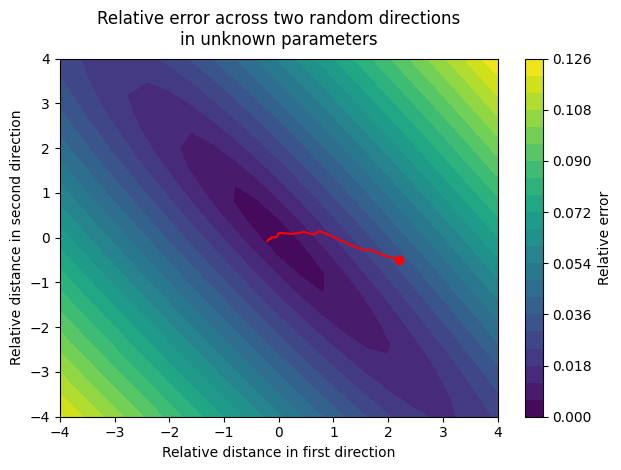

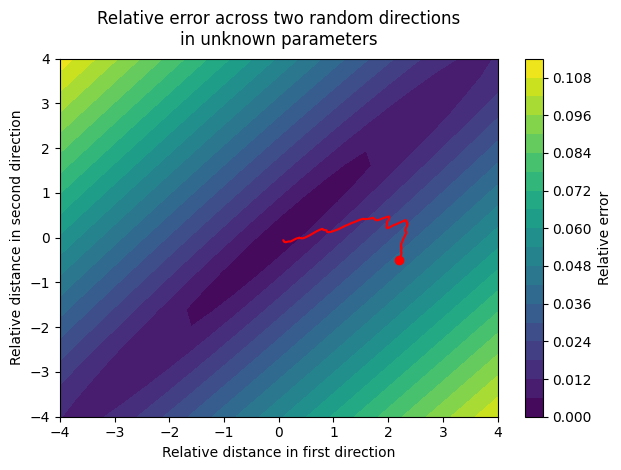

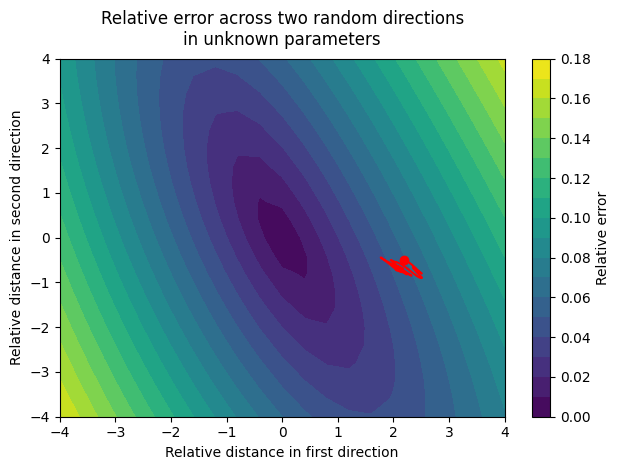

In [ ]:
for i, (surface_result, trajectory_result) in enumerate(
    zip(surface_results, trajectory_results)
):
    fig, ax = plt.subplots(1, 1)

    errors, xls, yls = surface_result
    es.plot_surface(fig, ax, errors, xls, yls)

    _, cs_coordinates = trajectory_result
    es.plot_trajectory(fig, ax, cs_coordinates)

    ax.set_xlabel("Relative distance in first direction")
    ax.set_ylabel("Relative distance in second direction")
    ax.set_title(
        "Relative error across two random directions\nin unknown parameters",
        pad=10,
    )
    fig.tight_layout()
    fig.savefig(
        os.path.join(FIGURES_FOLDER, f"error-surface_{i:0>3}.svg"),
        format="svg",
    )